### TODO
- For Schleife über die Querschnitts dicken funktioniert nicht -> Ergibt einen Dataframe aber müsst bei aktueller Struktur pro dicke einen DF erstellen und die jeweils in Excel schreiben. So muss alles hier für jede QS Stärke seperat gestartet werden. Zudem muss beim ersten durchlauf eine leere Excel Datei mit dem entsprechenden Namen erstellt werden.

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os
from os.path import join as os_join
import pandas as pd

from source.model import BeamModel
import source.postprocess as postprocess
from source.utilities import utilities as utils
from source.Querschnitte import nEck, KreisRing
import source.utilities.global_definitions as GD
from source.utilities import holz


2D Euler-Bernoulli Balken:

x-Achse: Längsrichtung
y-Achse: Querrichtung
gamma: Verdrehung
Biegung um z-Achse
(keine Torsion)

![Balken](Beschreibungen/Balken_cosy_klein.png)

# Definieren der (Grund) Geometrischen sowie der Material Parameter

Abschnittsweise veränderliche Querschnittswerte werden nach erstellen der Querschnitte nEck und KreisRing ergänzt: 'defined on intervals'

Derzeit macht es vieles einfacher wenn die Anzahl der elemente des Balken 'n_elements' gleich der Ebenen anzahl des Modells ist. 


In [7]:
parameters = {
               'dimension': '2D',
                'n_elements': 13,
                'lx_total_beam': 110,
                'material_density': 904,# 500,#42, #für dynamische Berechnung äquivalenter Wert
                'total_mass_tower': 668390,# aus RFEM
                'nacelle_mass': 287920.5,# RFEM: 267910,# IEA37: 191000, # Gondel Masse in kg
                'vorspannkraft':12*2.5E+06, # N
                'imperfektion':0.005, # m/m 
                'E_Modul': 12000E+06,# N/m²
                'nu': 0.1, # querdehnung
                'damping_coeff': 0.025,
                'nodes_per_elem': 2,
                'Iz': 51.0,# Not used if defined on intervals
                'dofs_of_bc':[0,1,2], # Einspannung
                'type_of_bc':'clamped',#'clamped',# or 'spring'
                'spring_stiffness':[1E+13,2E+13], # Federsteifigkeit am Boden in u und gamma richtung Bögl 40 GNm/rad
                'dynamic_load_file': os_join(*["inputs","forces","dynamic_force_11_nodes.npy"]),
                'eigen_freqs_target':[0.133,0.79,3.0], 
                'defined_on_intervals':[] # kann gefüllt werden mit einer pickle datei 
            }
n_nodes = parameters['n_elements']+1

holzgüte = 'C24'

werkstoff_parameter = holz.charakteristische_werte[holzgüte]
parameters['material_density'] = werkstoff_parameter['rhok']
parameters['E_Modul'] = werkstoff_parameter['E0mean']

nachweis_parameter = holz.HOLZBAU

# Ergebnisse in einem DataFrame speichern - reihe = Höhe; Spalte = Ergebniss
# https://stackoverflow.com/questions/32370402/giving-a-column-multiple-indexes-headers 
# https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

grund_parameter_df = pd.DataFrame() # grundlegende parameter die untersucht werden

results_excel = os_join(*['output','Berechnungs_Ergebnisse.xlsx'])#_'+ holzgüte + 
querschnitts_excel = os_join(*['output','Querschnittswerte.xlsx'])

# Querschnittsdefinition

- mit create_cross_sections.py können Querschnitte (nEck und KreisRing) erstellt werden und als dictonary in einer pickle Datei gespeichert. (Gedacht für den Systematischen Vergleich mehrerer QS)
- Querschnitte müssen immer über Querschnitt.export_to_dict_pkl() gespeichert werden 
- diese müssen geladen werden (eindeutige Identifikation über den Namen der Datei) und den aktuellen parametern angehängt werden (wird diese Funktion verwendet werden nötige Variablen wie die totale länge automatisch angepasst)

Sollen mehrere Querschnitte untersucht werden ist gedacht eine Liste an Dateien mit den unterschiedlichen Querschnitten zu erstellen.

In [8]:
# um zwischen den Alternativen zu Wählen
querschnitts_dateien_laden = False

#### Alternative 1: Querschnitte Laden aus Dateien erstellt mit "create_cross_sections.py"

In [9]:
if querschnitts_dateien_laden:
    d_unten = 12
    ecken = [12]#,10,8] #
    höhen = [110]#,130,140,150,160]#]
    t_längslagen = [40]#, 48, 56] # cm
    t_querlagen = 8 #cm
    
    querschnitte = []#, 'Kreisring_d12.pkl']#'8Eck.pkl','10Eck.pkl', 
    for höhe in höhen:
        for t_längslage in t_längslagen:
            filename = 'Ring_' + str(höhe) + '_du' + str(d_unten) + '_' + holzgüte + '_tX' + str(t_längslage) + '_tY' +str(t_querlagen)+ '.pkl'
            querschnitt_object = utils.load_object_from_pkl(os_join(*['inputs', 'geometry', 'objekte', filename]))
            querschnitte.append(querschnitt_object)
            for n_ecken in ecken:
                filename = str(n_ecken) + 'Eck_' + 'h'+ str(höhe)  + '_du' + str(d_unten) + '_' + holzgüte + '_tX' + str(t_längslage) + '_tY' +str(t_querlagen)+ '.pkl'
                querschnitt_object = utils.load_object_from_pkl(os_join(*['inputs', 'geometry', 'objekte', filename]))
                querschnitte.append(querschnitt_object)

    # erste Spalte im Dataframe sollten die höhen sein 
    # results_df['z_coords_h' + str(höhe)] = querschnitt_object.section_absolute_heights     

#### Alternative 2: Direkt definieren eines / mehrerer Querschnitte

In [12]:
if not querschnitts_dateien_laden:
        querschnitte = []
        d_oben = 3.4 # durchmesser am Kopf immer so
        d_unten = 12 
        d_knick = [7,6.5,6]
        ebene_i_knick = 7
        n_ebenen = 14
        nabenhöhe = 110
        if n_ebenen != n_nodes:
                print ('WARNING: besser gleich viele Ebenen wie Knoten für die Berechnung')
        höhen_parameter = {}
        d_achse = np.linspace(12, 3.4, n_ebenen)
        d_achse_knick =[]
        for d_knick_i in d_knick:
                d_achse_u = np.linspace(d_unten, d_knick_i, ebene_i_knick+1)
                d_achse_o = np.linspace(d_knick_i, d_oben, n_ebenen-ebene_i_knick)
                d_achse_knick.append(np.concatenate((d_achse_u, d_achse_o[1:])))

        print ('d_achse gerade Knoten 7', d_achse[ebene_i_knick])
        for i in d_achse_knick:
                print ('d_achse Knick Knoten 7', i[ebene_i_knick])
        
        höhen_parameter['absolute_höhen'] = np.linspace(0, nabenhöhe, n_ebenen)
        höhen_parameter['hfract'] = höhen_parameter['absolute_höhen']/höhen_parameter['absolute_höhen'][-1]

        #plt.plot(d_achse_knick,höhen_parameter['absolute_höhen'])
        #plt.plot(höhen_parameter['absolute_höhen'], d_achse_knick)
        #plt.show()

        lagen_aufbau = [{'ortho':'X','ti':0.16},
                        {'ortho':'Y','ti':0.04},
                        {'ortho':'X','ti':0.08},
                        {'ortho':'Y','ti':0.04},
                        {'ortho':'X','ti':0.16}]

        einheiten_input = {'Kraft':'N', 'Moment':'Nm', 'Festigkeit':'N/mm²', 'Länge':'m'}

        d_to_analyse = {'gerade':d_achse, 'Knick_7':d_achse_knick[0], 'Knick_6.5':d_achse_knick[1], 'Knick_6':d_achse_knick[2]}
        qs_werte = []

        for label, d_achse_i in d_to_analyse.items():
                kreis_ring = KreisRing(d_achse_i, cd = 1.1, lagen_aufbau=lagen_aufbau,
                                        holz_parameter = werkstoff_parameter, 
                                        nachweis_parameter = nachweis_parameter,
                                        hoehen_parameter= höhen_parameter, einheiten=einheiten_input)

                kreis_ring.name += ' ' + label
                for values in kreis_ring.querschnitts_werte.values():
                        qs_werte.append(values)
                querschnitte.append(kreis_ring)

        qs_header = pd.MultiIndex.from_product([list(d_to_analyse.keys()), list(kreis_ring.querschnitts_werte.keys())])
        qs_werte=np.array(qs_werte).transpose()
        qs_df = pd.DataFrame(qs_werte, columns=qs_header)
        holz_df = pd.DataFrame(werkstoff_parameter, index=[0])
        

        n_ecken = 12                     
        current_nEck = nEck(n_ecken, d_achse, cd = 1.3, lagen_aufbau=lagen_aufbau, 
                                holz_parameter = werkstoff_parameter, 
                                nachweis_parameter = nachweis_parameter,
                                hoehen_parameter= höhen_parameter, einheiten=einheiten_input)

        # wird genauso auch zum 'Berechnungs_Ergebnisse' Excel hinzugefügt
        with pd.ExcelWriter(querschnitts_excel, mode= 'w', engine="openpyxl") as writer:# --> mode = 'w', if_sheet_exists='overlay'
                holz_df.to_excel(writer, sheet_name= 'QS_Werte', startrow=0, startcol=0, index=False)#, float_format='%.4f')
                qs_df.to_excel(writer, sheet_name= 'QS_Werte', startrow=4, startcol=0)#, float_format='%.4f'), index=False
        
        utils.zellen_groeße_formatieren(querschnitts_excel, worksheet= 'QS_Werte', cell_width=15, n_cols=len(holz_df.columns)*2+1)
        
        #querschnitte =[kreis_ring]#, current_nEck]

        # results_df['z_coords'] = höhen_parameter['absolute_höhen']


d_achse gerade Knoten 7 7.36923076923077
d_achse Knick Knoten 7 7.0
d_achse Knick Knoten 7 6.5
d_achse Knick Knoten 7 6.0


### Dataframe
- Wird genutzt um die Ergebnisse am Ende einfach in ein Excel zu schreiben
- Der Dataframe muss leer initialisiert werden um verschiedene Level an Headern zu verwenden -> genau diese Namen an headern müssen dann benutzt werden um den Dataframe zu füllen

In [13]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

df_results_header = [[],[], []] # 1. Liste = 1. Level usw...

for qs in querschnitte:
    if qs.max_height not in df_results_header[0]:
        df_results_header[0].append(qs.max_height)
    if qs.name not in df_results_header[1]:
        df_results_header[1].append(qs.name)# + ' tX ' + str(qs.t_laengslagen) + ' tY ' + str(qs.t_querlagen))

    # Berechnungsergebnisse - dritte Ebene:
    if not df_results_header[2]: 
        df_results_header[2].append('Höhe [' + qs.einheiten['Länge'] + ']') 
        df_results_header[2].append(GD.GREEK_UNICODE['sigma'] + '_zug [' + qs.einheiten['Normalspannung'] + ']') 
        df_results_header[2].append(GD.GREEK_UNICODE['sigma'] + '_druck [' + qs.einheiten['Normalspannung'] + ']') 
        df_results_header[2].append('Vorspannkraft [MN]') 
        df_results_header[2].append('Ausnutzung druck') 

        # df_results_header[2].append(GD.GREEK_UNICODE['sigma'] + '_N [' + qs.einheiten['Normalspannung'] + ']') 
        # df_results_header[2].append(GD.GREEK_UNICODE['sigma'] + '_M [' + qs.einheiten['Normalspannung'] + ']') 

df_results_header = pd.MultiIndex.from_product(df_results_header, names=['Nabenhöhe', 'Querschnitt', 'Ergebnisse'])
results_df = pd.DataFrame(columns=df_results_header)

# Äußere Belastung 


- Windkraft F_w über die Höhe wird nach DIN berechnet (cscd vernachlässigt Bert = 1.01, DIBt 9.3.2: muss im Parkzustand berücksichtigt werden im Analgenbetrieb nicht).

![Formel](Beschreibungen/Fw_formel.PNG)
    
- Angabe eines eigenen cd / cf Werts (drag coefficient bzw. Kraftbeiwert)

- Kopflasten aus IEA37 Min/Max Tabellen

- Schiefstellung 5 mm/m (DIBt Windenergieanlagen Richtlinie 2012 Kapitel 7.4)
- Teilsicherheitsbeiwerte nach IEC 

### Einwirkungsdauer

- Einteilung der Lasten nach dauer 'kurz' und 'ständig' (durch keys in dictonaries)

### Dateinamens Konvention

Die Lasten werden/müssen in einer .npy datei gespeichert werden um vom beam gelesen werden zu können. Für die Dateinamen wird folgende bezeichnugn festgelegt:

- K-IEA@maxFx_ = Kopflasten + Quelle der min max tabelle + angabe aus welcher reihe der min max tabelle 

- W-v17cd1.5_ = Windlast + Basiswindgeschwindigeit + cd Wert

- D-kurz = Dauer der Einwirkung


In [14]:
kopf_lasten_IEA = {'Fx':1.17E+06,'Fy':4.80E+04, 'Fz':-3.64E+06, 'Mx':5.98E+06, 'My':3.24E+06, 'Mz':2.31E+06}#
kopf_lasten_IEA_0 = {'Fx':0,'Fy':0, 'Fz':-0, 'Mx':0, 'My':0, 'Mz':0} # als platzhalter um vorhanden Funktionen einfacher verwenden zu können
kopf_lasten_beam = utils.convert_coordinate_system_and_consider_einwirkungsdauer(kopf_lasten_IEA) # Koordinaten definiton abweichend + gleichzeitig einteilung der Lasten in Einwirkungsdauer
kopf_lasten_beam_0 = utils.convert_coordinate_system_and_consider_einwirkungsdauer(kopf_lasten_IEA_0) # Koordinaten definiton abweichend
lasten_dict_base = {'Fx':np.zeros(n_nodes), 'Fy':np.zeros(n_nodes), 'Mz':np.zeros(n_nodes)}

einwirkungsdauer = ['ständig','kurz', 'egal']
gamma_q = 1.35

import source.DIN_Windlasten as wind_DIN

basis_windgeschwindigkeit = 17
terrain_kategorie = 'II'
print ('Windbelastung aus:')
print ('    vb:', basis_windgeschwindigkeit)
print ('    terrain:', terrain_kategorie)
print ('    gamma_q:', gamma_q)
#wind_DIN.plot_DIN_all(basis_windgeschwindigkeit, categories=[terrain_kategorie])

wind_kraft_z = {}
lasten_files, lasten_dicts = {}, {}
grund_parameter_df['Querschnitt'] = [q.name for q in querschnitte]
grund_parameter_df['t [cm]'] = [q.wand_stärke for q in querschnitte]
grund_parameter_df['Nabenhöhe [m]'] = [q.section_absolute_heights[-1] for q in querschnitte]
grund_parameter_df['cd'] = [q.cd for q in querschnitte]

for querschnitt in querschnitte:
    # Infromationen vom QS Objekt holen
    QS_label = querschnitt.name
    cd = querschnitt.cd
    höhen_z = querschnitt.section_absolute_heights
    nabenhöhe = querschnitt.max_height
    d_achse = querschnitt.d_achse 

    # Ergebniss Daten vorbereiten -> leer initialisieren nur wenn noch nicht leer 
    if QS_label not in lasten_files:
        lasten_files[QS_label] = {}
        lasten_dicts[QS_label] = {}

    if nabenhöhe not in lasten_files[QS_label]:
        lasten_files[QS_label][nabenhöhe] = {}
        lasten_dicts[QS_label][nabenhöhe] = {}

    # Lastberechnung für den spezifischen QS
    wind_kraft_z, z_coords = wind_DIN.wind_kraft(vb=basis_windgeschwindigkeit, category=terrain_kategorie, height=höhen_z, cd = cd, Aref=d_achse)
    knoten_wind_kraft_z = utils.linien_last_to_knoten_last(wind_kraft_z, höhen_z, gamma_q = 1.35) # NOTE gamma_q nach IEC 
    #postprocess.plot_along_height(knoten_wind_kraft_z, z_coords, label='wind_kraft [N]')

    lasten_dict_nur_wind = utils.update_lasten_dict(lasten_dict_base, knoten_wind_kraft_z, kopf_lasten_beam_0['egal'])
    lasten_dicts[QS_label][nabenhöhe]['egal']  = utils.update_lasten_dict(lasten_dict_base, knoten_wind_kraft_z, kopf_lasten_beam['egal']) #unabhängig von der Einwirkungsdauer
    # _____Sortiert nach Einwirkungsdauer __________________________
    lasten_dicts[QS_label][nabenhöhe]['kurz'] = utils.update_lasten_dict(lasten_dict_base, knoten_wind_kraft_z, kopf_lasten_beam['kurz'])
    lasten_dicts[QS_label][nabenhöhe]['ständig']  = utils.update_lasten_dict(lasten_dict_base, wind_kraft = None, kopflasten = kopf_lasten_beam['ständig'])

    # ____________ LASTEN DATEI GENERIEREN ___________________________
    for dauer in einwirkungsdauer:
        filename = 'K-IEA@maxFx_' + 'W-v' +str(basis_windgeschwindigkeit) + 'cd' + str(cd) + '_D-' + dauer
        lasten_files[QS_label][nabenhöhe][dauer] = utils.generate_lasten_file(n_nodes, lasten_dicts[QS_label][nabenhöhe][dauer], file_base_name=filename)

    if QS_label == 'Ring' and nabenhöhe == 110:
        postprocess.plot_dict_subplots(lasten_dict_nur_wind, höhen_z, title='Windkraft ' + QS_label, unit='kN')
        postprocess.plot_dict_subplots(lasten_dicts[QS_label][nabenhöhe]['egal'], höhen_z, title='Windkraft + Kopflasten gesamt ' + QS_label, unit = 'kN')


Windbelastung aus:
    vb: 17
    terrain: II
    gamma_q: 1.35


# Schnittgrößen

- Balkenmodell initiieren (für jeden Querschnitt)
- Statisch Berechnung -> Schnittgrößen entlang der Höhe
- Berechnung für die vom Querschnitt abhängigen Lasten
- Unterscheidung der Einwirkungsdauer 
- Eigengewicht des Turms mit einbeziehen -> 'ständig'
- Horizontale ersatzlast infolge Schiefstellung (ungünstig zur wirkenden Horizontalkraft addieren) -> 'ständig'
- Vergleich: Moment am Fuß IEA @ max Fx: 128 MNm

### TODO
- Teilsicherheitsbeiwert Eigengewicht komplexer -> Kapitel 7.6.2.2 Tabelle 3 IEC 61400
- bis dahin gamma_g = 1.35

Ring gerade 110.0 m
     Gesamt Volumen des Querschnitts [m³]: 1277.25
     Gesamt Gewichtskraft am Fuß [MN]: -5.76
     Frequenzen [Hz]: [0.52, 3.21, 8.525]
     Maximales Moment [MNm]: 164.51
     Maximales Moment ohne Kopflast [MNm]: 35.81


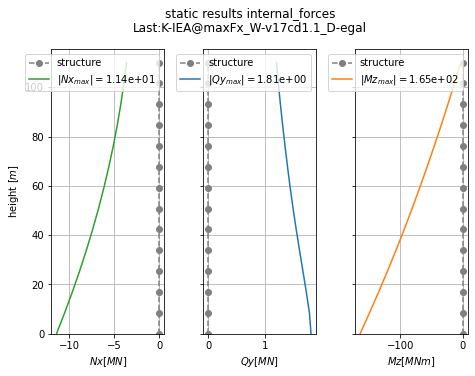

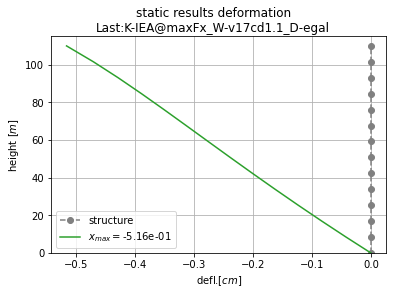

Ring Knick_7 110.0 m
     Gesamt Volumen des Querschnitts [m³]: 1246.62
     Gesamt Gewichtskraft am Fuß [MN]: -5.63
     Frequenzen [Hz]: [0.501, 3.154, 8.447]
     Maximales Moment [MNm]: 164.46
     Maximales Moment ohne Kopflast [MNm]: 35.76


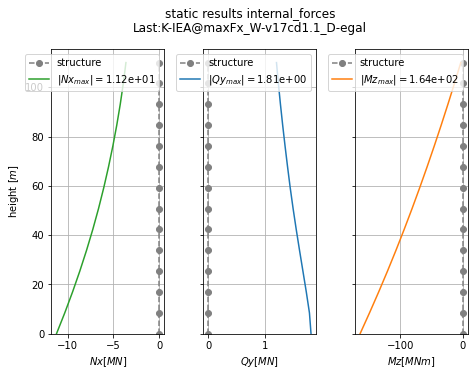

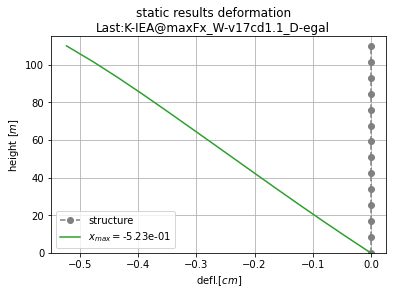

Ring Knick_6.5 110.0 m
     Gesamt Volumen des Querschnitts [m³]: 1205.15
     Gesamt Gewichtskraft am Fuß [MN]: -5.44
     Frequenzen [Hz]: [0.475, 3.081, 8.335]
     Maximales Moment [MNm]: 164.4
     Maximales Moment ohne Kopflast [MNm]: 35.7


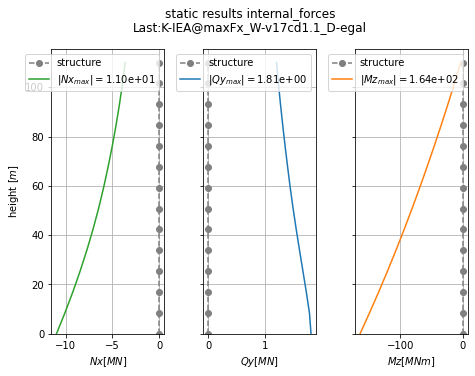

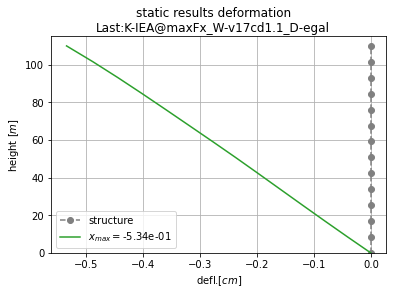

Ring Knick_6 110.0 m
     Gesamt Volumen des Querschnitts [m³]: 1163.68
     Gesamt Gewichtskraft am Fuß [MN]: -5.25
     Frequenzen [Hz]: [0.448, 3.008, 8.213]
     Maximales Moment [MNm]: 164.33
     Maximales Moment ohne Kopflast [MNm]: 35.63


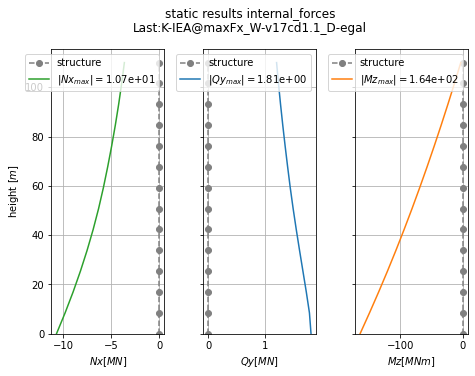

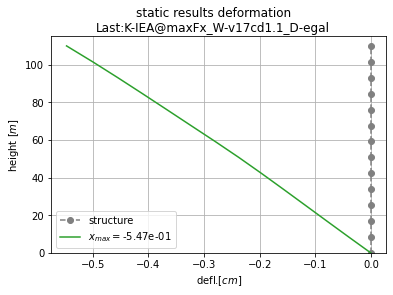

In [15]:
schnittgrößen = {}
for querschnitt in querschnitte:
    QS_label = querschnitt.name
    nabenhöhe = querschnitt.max_height

    if QS_label not in schnittgrößen:
        schnittgrößen[QS_label] = {}
    if nabenhöhe not in schnittgrößen[QS_label]:
        schnittgrößen[QS_label][nabenhöhe] = {}

    section_properties = querschnitt.section_parameters #os_join(*['inputs', 'geometry', querschnitts_name])

    parameters = utils.add_model_data_from_dict(section_properties, parameters, set_I_eff=False)

    beam = BeamModel(parameters, adjust_mass_density_for_total = False, optimize_frequencies_init=False , apply_k_geo=False)

    print (QS_label, nabenhöhe, 'm')
    print('     Gesamt Volumen des Querschnitts [m³]:', round(beam.volume,2))
    print ('     Gesamt Gewichtskraft am Fuß [MN]:',round(sum(beam.eigengewicht * GD.UNIT_SCALE['MN']),2))

    print ('     Frequenzen [Hz]:', [round(beam.eigenfrequencies[i],3) for i in range(3)])

    gamma_Q = 1.0 # Da lasten schon mit sichterheitsbeiwerte vorliegen 

    lasten_nach_dauer = {'ständig':{'eigengewicht':True, 'imperfektion':True},
                         'egal':{'eigengewicht':True, 'imperfektion':True},
                         'kurz':{'eigengewicht':False, 'imperfektion':False}}
    for dauer in einwirkungsdauer:
        lasten_file = lasten_files[QS_label][nabenhöhe][dauer]
        lasten_label = os.path.splitext(os.path.basename(lasten_file))[0]

        schnittgrößen[QS_label][nabenhöhe][dauer] = beam.static_analysis_solve(load_vector_file=lasten_file, return_result=True,
                                                                    add_eigengewicht=lasten_nach_dauer[dauer]['eigengewicht'], 
                                                                    add_imperfektion = lasten_nach_dauer[dauer]['imperfektion'],
                                                                    gamma_g=1.35)

    print ('     Maximales Moment [MNm]:', round(max(abs(schnittgrößen[QS_label][nabenhöhe]['egal']['g'])) * utils.unit_conversion('Nm', 'MNm'),2))   
    print ('     Maximales Moment ohne Kopflast [MNm]:', round((max(abs(schnittgrößen[QS_label][nabenhöhe]['egal']['g'])) - kopf_lasten_IEA['Fx']*nabenhöhe) * utils.unit_conversion('Nm', 'MNm'),2))   
                                                                 
    if nabenhöhe == 110:
        postprocess.plot_static_result_forces(beam, 'internal_forces', ['x','y','g'], unit='MN', title_suffix='Last:' + lasten_label, figsize_scale = 1.1)
        postprocess.plot_static_result(beam, 'deformation', ['x'], unit='cm',title_suffix='Last:' + lasten_label,)

    

    #results_df['Mz ' + QS_label_kurz + ' [MNm]'] = SGR_wind_kopf['g'] * utils.unit_conversion('Nm', 'MNm')
    #results_df['Qy ' + QS_label_kurz + ' [MN]'] = SGR_wind_kopf['y'] * utils.unit_conversion('N', 'MN')
    #results_df['Nx ' + QS_label_kurz + ' [MN]'] = SGR_wind_kopf['x'] * utils.unit_conversion('N', 'MN')



# Berechnung der Spannungen

- Für die Liste an Querschnitten werden mit den Entsprechenden Schnittgrößen die Spannungen berechnet
- Bisher nur Normalspannugen infolge Biegung und Normalkraft
- Ausnutzung aufgrund der Druckspannungen aus Moment, Imperfektion und Normalkraft 
- Druckspannung infolge Vorspannkraft wird in einer ersten Annährung durch die Zugspannung abgedeckt
- der Dataframe wird gefüllt und in eine Excel geschrieben
- WICHTIG: der pd.ExcelWriter unterscheided zwischen mode 'w' = 'write' und 'a' = 'append'. Für 'w' wird alles neu geschrieben also der Inhalt der Datei quasi erst gelöscht und dann gefüllt. Mit 'a' kann eine Vorhandene Datei erweitert werden -> mit if_sheet_exists = 'overlay' werden auch die einzelnen Arbeitsblätter nicht gelöscht bevor sie geschrieben werden

In [19]:
max_ausnutzung = {}
for querschnitt in querschnitte:
  QS_label = querschnitt.name
  #QS_label_df = QS_label +  ' tX ' + str(querschnitt.t_laengslagen) + ' tY ' + str(querschnitt.t_querlagen)
  nabenhöhe = querschnitt.max_height
  t = round(querschnitt.wand_stärke * 100) # cm
  tX = querschnitt.t_laengslagen * 100
  tY = querschnitt.t_querlagen * 100
  #print ('Spannungs Berechnung für', QS_label)
  if QS_label not in max_ausnutzung:
    max_ausnutzung[QS_label] = {}
    
  last = utils.parse_schnittgrößen_labels(schnittgrößen[QS_label][nabenhöhe])

  querschnitt.calculate_vorspannkraft_sections(last, unit = 'MN')
  #print (querschnitt.vorspannkraft_ges_fuge)

  querschnitt.calculate_ausnutzung_normalspannung(last, add_vorspannkraft_grob=True)
  # NOTE results_df.loc[:, (Level1, Level2, Level3)] = daten
  results_df.loc[:,(nabenhöhe, QS_label, 'Höhe [' + querschnitt.einheiten['Länge'] + ']')] = np.around(querschnitt.section_absolute_heights,2)

  results_df.loc[:,(nabenhöhe, QS_label, GD.GREEK_UNICODE['sigma'] + '_zug [' + querschnitt.einheiten['Normalspannung'] + ']')] = querschnitt.sigma_zug_design
  results_df.loc[:,(nabenhöhe, QS_label, GD.GREEK_UNICODE['sigma'] + '_druck [' + querschnitt.einheiten['Normalspannung'] + ']')] = querschnitt.sigma_druck_design
  results_df.loc[:,(nabenhöhe, QS_label, 'Ausnutzung druck')] = np.around(querschnitt.ausnutzung_druck,3)
  max_eta = max(querschnitt.ausnutzung_druck)
  max_ausnutzung[QS_label][str(nabenhöhe) + ' m'] = max_eta

  results_df.loc[:,(nabenhöhe, QS_label, 'Vorspannkraft [MN]')] = querschnitt.vorspannkraft_ges_fuge
  
  # results_df.loc[:,(nabenhöhe, QS_label, GD.GREEK_UNICODE['sigma'] + '_N [' + querschnitt.einheiten['Normalspannung'] + ']')] = querschnitt.sigma_N_design
  # results_df.loc[:,(nabenhöhe, QS_label, GD.GREEK_UNICODE['sigma'] + '_M [' + querschnitt.einheiten['Normalspannung'] + ']')] = querschnitt.sigma_M_design
  

max_results_df = pd.DataFrame(max_ausnutzung)
print ('Maximale Ausnutzungen')
print (max_results_df)

#print ('Vorspannkraft [MN]')
#print ( results_df[110, 'Ring', 'Vorspannkraft [MN]'])

#______________________ ALLES IN EXCEL SPEICHERN _________________________________________________________________________________________
d_rows = grund_parameter_df.shape[0] + 7 + results_df.shape[0]
# bisschen arg händisch bisher -> um Ergebnisse verschiedener QS Wandstärken in einer Datei untereinander zu schreiben
start_row_ti = {48:0, 56:d_rows, 64:2*d_rows}
start_row_max_ti = {48:1, 56:1+8, 64:1+16}

with pd.ExcelWriter(results_excel, mode= 'w', engine="openpyxl") as writer:# --> mode = 'w', if_sheet_exists='overlay'
  nrows = start_row_ti[int(t)] + grund_parameter_df.shape[0]
  # TODO macht gerade nur sinn die QS Werte mit hier rein zu schreiben wenn es eineinzelner QS ist
  holz_df.to_excel(writer, sheet_name= 'QS_Werte', startrow=0, startcol=0, index=False)#
  qs_df.to_excel(writer, sheet_name= 'QS_Werte', startrow=4, startcol=0)#, index=False
  results_df.to_excel(writer, sheet_name= 'Berechnungs_Ergebnisse', startrow=nrows+2, startcol=0, index=True)#, float_format='%.4f')
  grund_parameter_df.to_excel(writer, sheet_name= 'Berechnungs_Ergebnisse', startrow=start_row_ti[int(t)], startcol=0, index=False)
  max_results_df.to_excel(writer, sheet_name= 'Ausnutzungen_max', startrow=start_row_max_ti[t], index=True)

utils.zellen_groeße_formatieren(results_excel, worksheet= 'QS_Werte', cell_width=15, n_cols=len(qs_df.columns)+1)
utils.zellen_groeße_formatieren(results_excel, worksheet= 'Berechnungs_Ergebnisse', cell_width=18, n_cols=len(results_df.columns)+1)
utils.add_databar_color(results_excel, worksheet = 'Berechnungs_Ergebnisse', columns = ['F9:F24', 'K9:K24', 'P9:P24', 'U9:U24'])
utils.zellen_groeße_formatieren(results_excel, worksheet= 'Ausnutzungen_max', cell_width=20, n_cols=len(max_results_df.columns)+1)
utils.zelle_beschriften(results_excel, 'Ausnutzungen_max', 'B' + str(start_row_max_ti[t]), 
                       't, tX, tY [cm] ' + ', '.join([str(int(t)), str(round(tX,1)), str(round(tY,1))]) ,'B' + str(start_row_max_ti[t])+ ':E'+ str(start_row_max_ti[t]))

              

print ('Ergebnisse in ', results_excel, 'geschrieben')

    

Maximale Ausnutzungen
         Ring gerade  Ring Knick_7  Ring Knick_6.5  Ring Knick_6
110.0 m      0.46013      0.508807         0.59247      0.698542
Ergebnisse in  output\Berechnungs_Ergebnisse.xlsx geschrieben
